<a href="https://colab.research.google.com/github/AriyantGit/CT-Scan-Image-Classification-Using-ResNet50/blob/main/covid_19_cnn_model_using_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Go to Google Drive, upload this notebook and dataset folders. Rigth click notebook, choose Open with -> Google Colab


> * To activate GPU in Colab, go to **Runtime -> Change Runtime Type**. Under **Hardware accelerator** choose **GPU** 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import all dependencies**

In [2]:
from builtins import range, input
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image,image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# **Here are a few parameters used in deep learning**

In [3]:
#define size to which images are to be resized
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

# training config:
epochs = 250
batch_size = 32
num_classes = 2

# **Train Test Split**

In [6]:
data_dir="/content/drive/MyDrive/Capstone_project"
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2480 files belonging to 2 classes.
Using 1984 files for training.
Found 2480 files belonging to 2 classes.
Using 496 files for validation.


# **Normalization**
Model takes images in the form of array of pixels. Hence convert into array and normalize

In [7]:
normalization_layer = Rescaling(1./255)
norm_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
norm_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


# Visualize a few images from Training and Test sets

In [22]:
def plotimg(data,title):
    plt.figure(figsize=(10, 10))
    class_names = data.class_names
    plt.suptitle(title, fontsize=24)
    for images, labels in data.take(1):
        for i in range(32):
            ax = plt.subplot(6, 6, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i])])
            plt.axis("off")

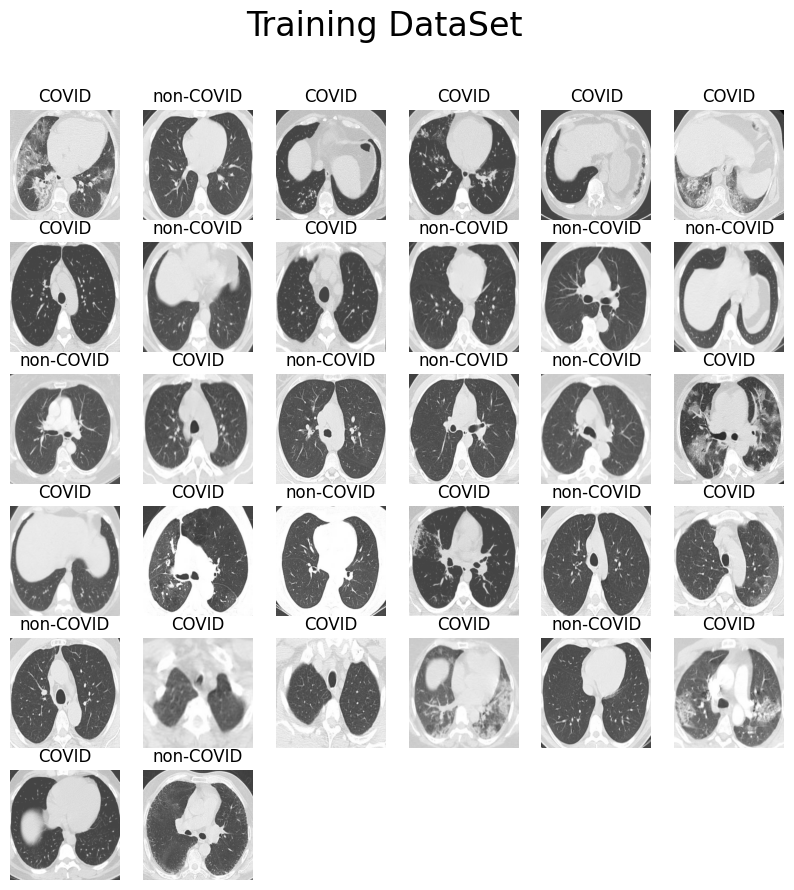

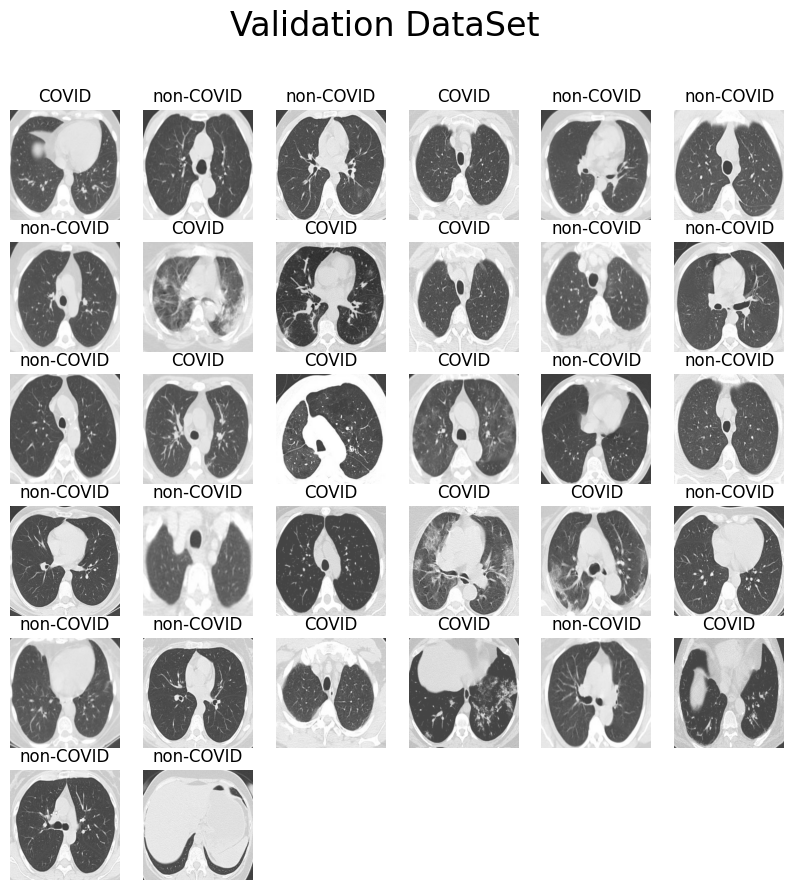

In [23]:
#Printing Some Training Data
plotimg(train_ds,"Training DataSet")
#Printing Some Testing Data
plotimg(val_ds,"Validation DataSet")

**Import Early Stoping From Keras**

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# **Custome Early Stop For our Model**

In [25]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        patience=15,
        verbose=1
    )
]

# Building Model With ResNet50 Architechture

In [26]:
resnet = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)),classes = num_classes)


94765736/94765736 [==============================] - 1s 0us/step


### Don't train the existing weights

In [27]:
for layer in resnet.layers:
    layer.trainable = False

# Fully Connected Layers

In [28]:
flatten = Flatten(name="flatten")(resnet.output)

outputs = Dropout(0.5)(flatten)
prediction = Dense(2, activation = 'softmax')(outputs)

In [29]:
model = Model(inputs = resnet.input, outputs = prediction)

# Visualize Model

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [31]:
model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

# Image Augmentation
**To train on images at different positions, angles, flips,horizontal_flip etc**

In [32]:
dataugment = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


# Autotuning of Data

In [33]:
AUTOTUNE = tf.data.AUTOTUNE
norm_train_ds = norm_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
norm_val_ds = norm_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Training using ResNet50

In [34]:
history = model.fit(
        norm_train_ds,
        validation_data=norm_val_ds,
        epochs=epochs,
        callbacks=callbacks
    )

Epoch 1/250
62/62 [==============================] - 19s 222ms/step - loss: 1.6004 - accuracy: 0.5872 - val_loss: 1.2608 - val_accuracy: 0.5343
Epoch 2/250
62/62 [==============================] - 8s 125ms/step - loss: 0.8606 - accuracy: 0.6860 - val_loss: 1.2469 - val_accuracy: 0.5746
Epoch 3/250
62/62 [==============================] - 9s 141ms/step - loss: 0.7402 - accuracy: 0.7344 - val_loss: 1.1357 - val_accuracy: 0.5927
Epoch 4/250
62/62 [==============================] - 8s 122ms/step - loss: 0.6443 - accuracy: 0.7581 - val_loss: 1.0525 - val_accuracy: 0.6371
Epoch 5/250
62/62 [==============================] - 8s 123ms/step - loss: 0.7202 - accuracy: 0.7515 - val_loss: 0.6203 - val_accuracy: 0.7601
Epoch 6/250
62/62 [==============================] - 9s 139ms/step - loss: 0.7836 - accuracy: 0.7601 - val_loss: 0.3740 - val_accuracy: 0.8508
Epoch 7/250
62/62 [==============================] - 7s 121ms/step - loss: 0.6691 - accuracy: 0.7727 - val_loss: 0.3947 - val_accuracy: 0.842

# **Save Model and Weights**

In [ ]:
model.save('/content/drive/MyDrive/Covid Output/covid-19_ct_scan.h5')
model.save_weights('/content/drive/MyDrive/Covid Output/covid-19_ct_scan_weights.h5')

# **Load saved model**

In [8]:
# Load saved model
model = load_model('/content/drive/MyDrive/Covid Output/covid-19_ct_scan.h5')

# Making Predicions

In [9]:
y_pred = model.predict(norm_val_ds, batch_size=batch_size)

16/16 [==============================] - 67s 1s/step


In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        print('%.2f' % (probability[1]*100) + '% COVID')
  else:
        print('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
 

65.46% NonCOVID
100.00% NonCOVID
99.99% COVID
98.77% COVID
87.69% NonCOVID
98.60% NonCOVID
96.36% COVID
99.95% COVID
100.00% NonCOVID
93.04% COVID


# **Model Evaluation on Validation Dataset**

In [42]:
score = model.evaluate(norm_val_ds)
print('Test Loss: ', score[0])
print('Test accuracy: ', score[1])

16/16 [==============================] - 2s 97ms/step - loss: 0.3009 - accuracy: 0.9052
Test Loss:  0.3009469509124756
Test accuracy:  0.9052419066429138


* Our model loss Percentage is 29%
* Our Model Accuracy percentage is 89%

# Accuracy and Loss Plots

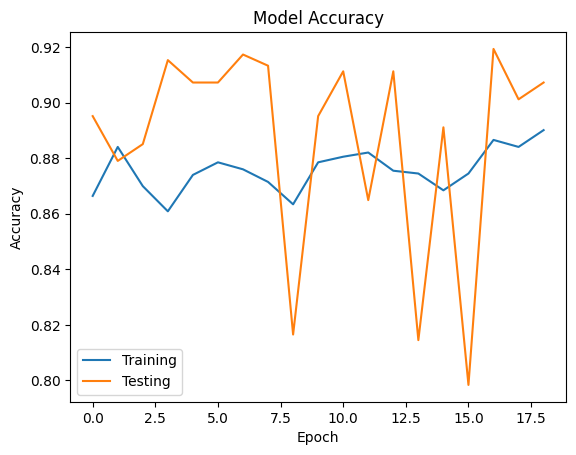

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Covid-19 CT Scan/covid-19_ct_scan_accuracy.png')
plt.show()

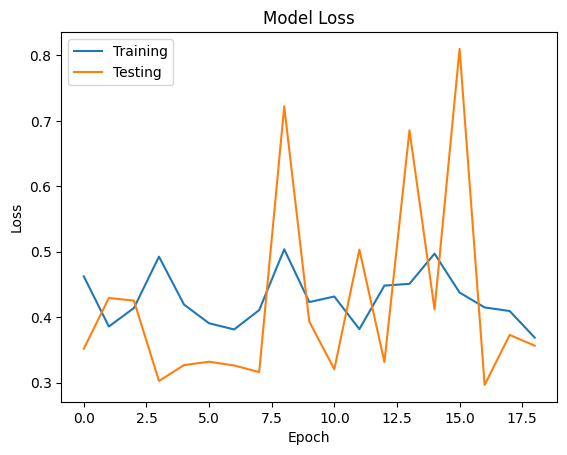

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Covid-19 CT Scan/covid-19_ct_scan_loss.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import itertools

In [43]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (8,8))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [ ]:
y_pred = np.argmax(y_pred, axis=1)

16/16 [==============================] - 6s 172ms/step


Confusion Matrix, Without Normalization
[[1 6]
 [2 7]]


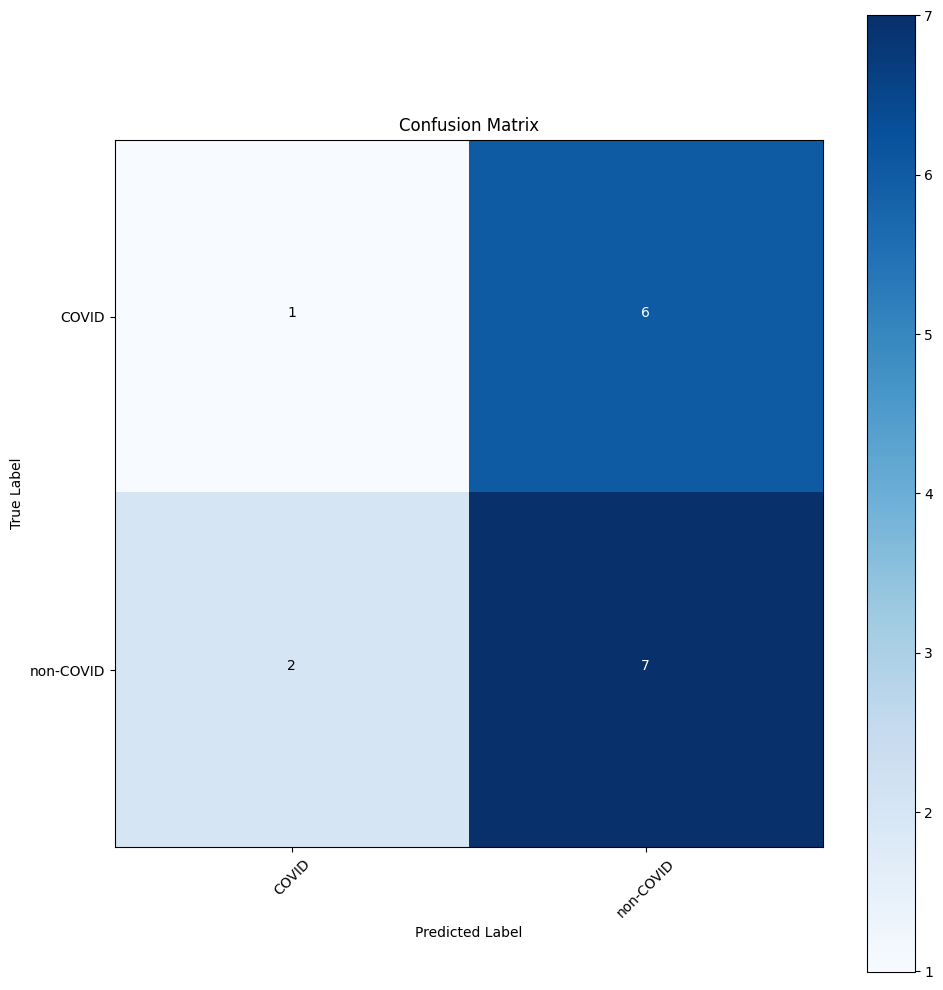

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_labels,y_pred[:16])
plot_confusion_matrix(cm= cm, classes= val_ds.class_names, title = 'Confusion Matrix')

In [ ]:
from keras.utils import load_img, img_to_array

test_image = load_img('/content/drive/MyDrive/Capstone_project/non-COVID/Non-Covid (10).png', target_size=(224, 224))
test_image = img_to_array(test_image)
test_image =np.expand_dims(test_image, axis = 0)

result = model.predict(test_image)

if result[0][0] > 0.5:
  prediction = 'Covid'
  print(prediction)

elif result[0][0] <0.5:
  prediction = 'Non-Covid'
  print(prediction)


1/1 [==============================] - 0s 37ms/step
Non-Covid
